## Demonstration of layer sharing on LeNet-5

In [1]:
import sys
sys.path.append('../')

In [2]:
import torch
import torch.nn as nn
import pandas as pd

from data.mnist import MnistDataset
from models.lenet.lenet import LeNet5
from utils.train import *
from utils.quantize import *
from utils.weight_sharing import *
from utils.plot import *

Parameters

In [3]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = None
EPOCHS = 100

NET_PATH = '../models/lenet/saves/lenet_tanh.save'
SAVE_DATA = '../results/test_share.csv'

Setting up the components

In [4]:
dataset = MnistDataset(BATCH_SIZE, '../data', val_split=0.5)
model = LeNet5(N_CLASSES, 'tanh')
criterion = nn.CrossEntropyLoss()

lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_opt, lam_train, lam_test)
ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Getting the network

In [5]:
optimizer = lam_opt(model)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings)

<Figure size 640x480 with 0 Axes>

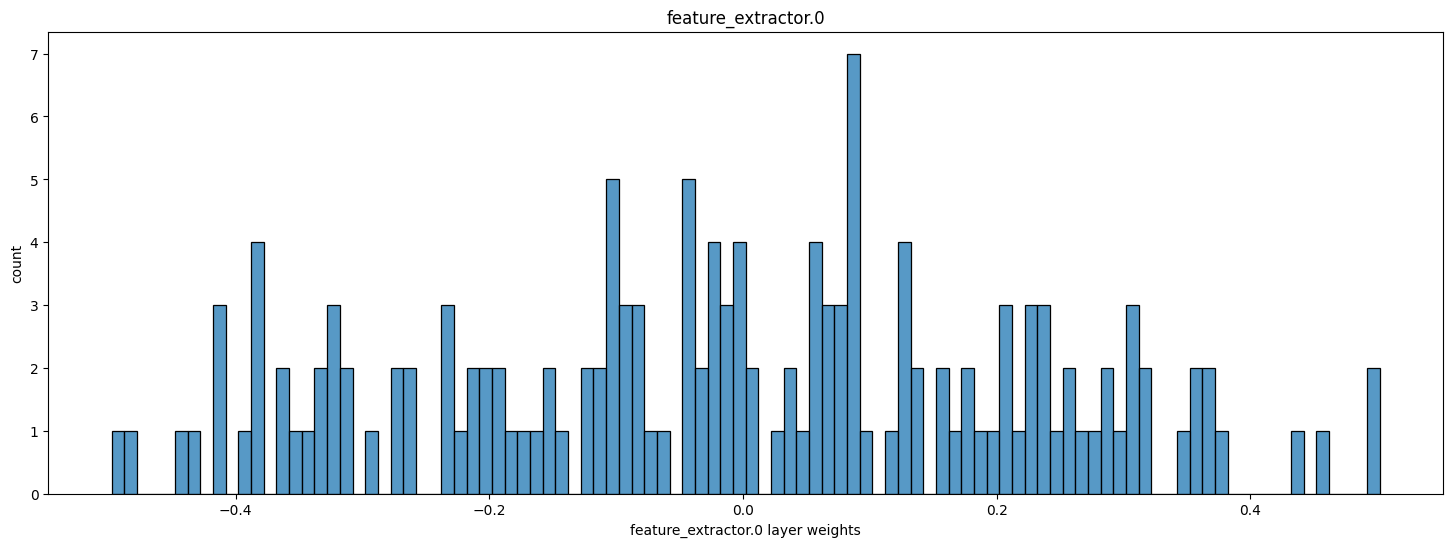

In [6]:
#sns.set(font_scale=1.5, style='white')
ws_controller.model_layers[0].plot_weight()

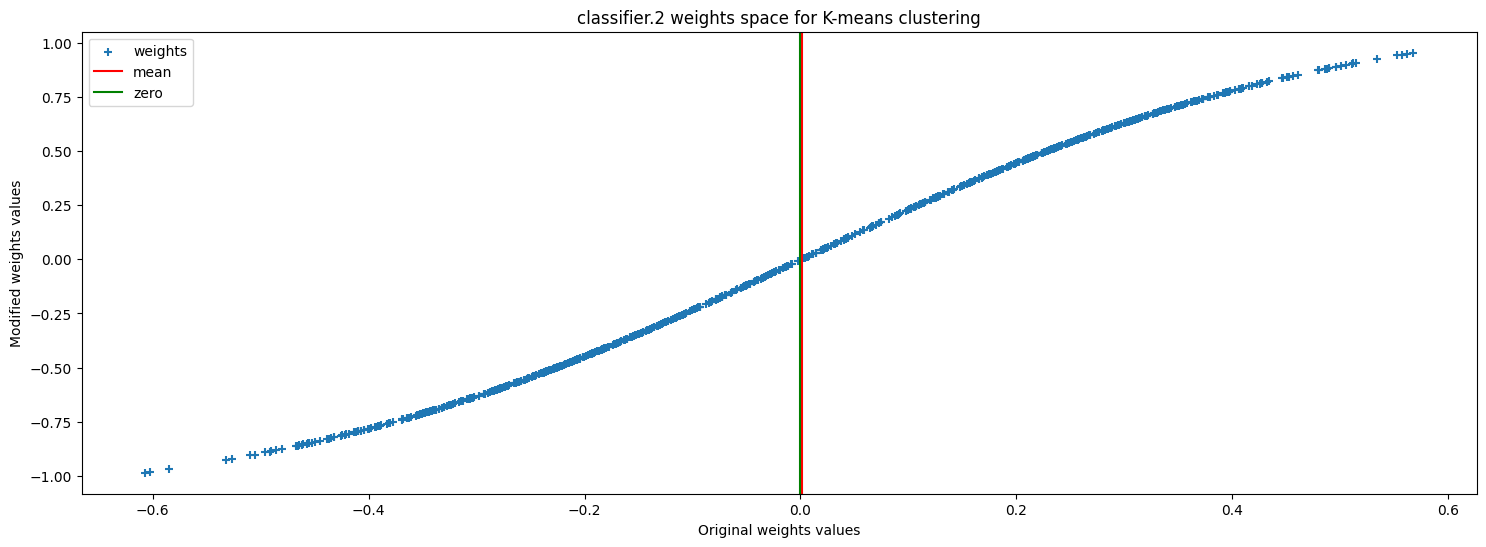

<Figure size 640x480 with 0 Axes>

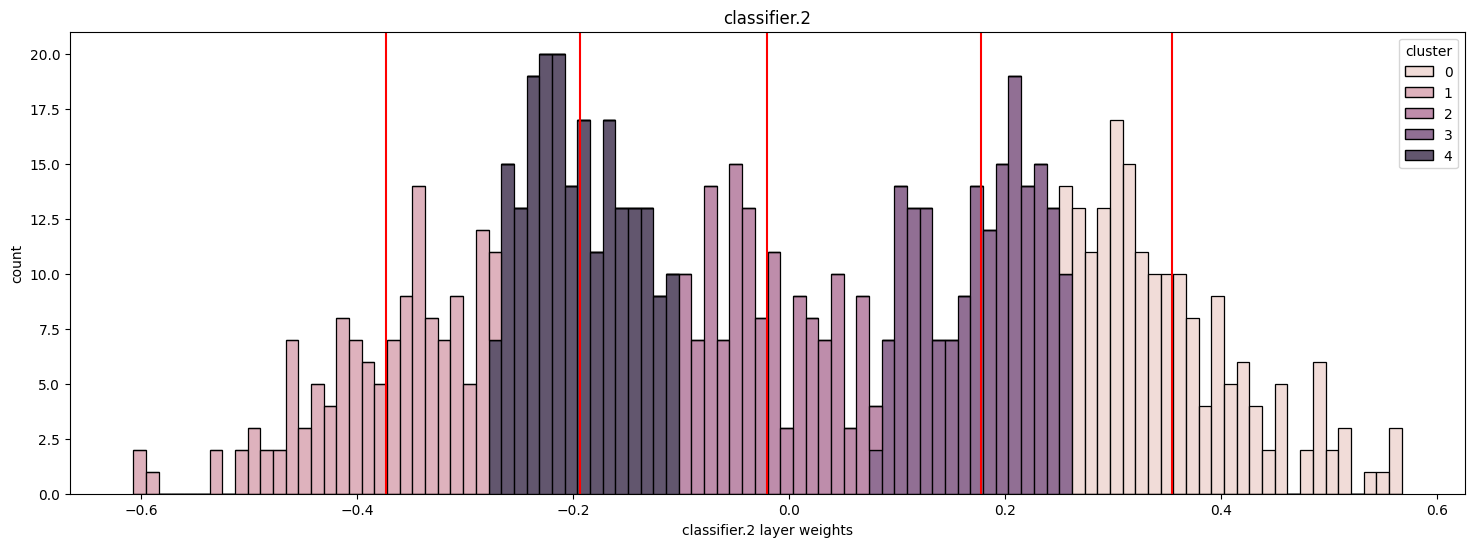

In [7]:
ws_controller.model_layers[4].share_weight(5, plot=True, mod_focus=2, mod_spread=1)
#plt.savefig('./results/plots/layer_kmeans.pdf')

TEST - Sharing the whole network to given parameters

In [ ]:

ws_controller.share([4, 4, 7, 10, 4], mods_focus=[2, 2, 2, 2, 2], mods_spread=[1, 1, 1, 1, 1])

# u tanh lenetu
# mods=[0, 0, 0, 0, 0] 'accuracy': 0.9738
# mods=[2, 2, 2, 2, 2] 'accuracy': 0.9808,

{'accuracy': 0.9808,
 'compression': 11.98956930434724,
 'times': {'train': 0,
  'share': 1.1427838802337646,
  'test': 11.187431812286377}}

<Figure size 640x480 with 0 Axes>

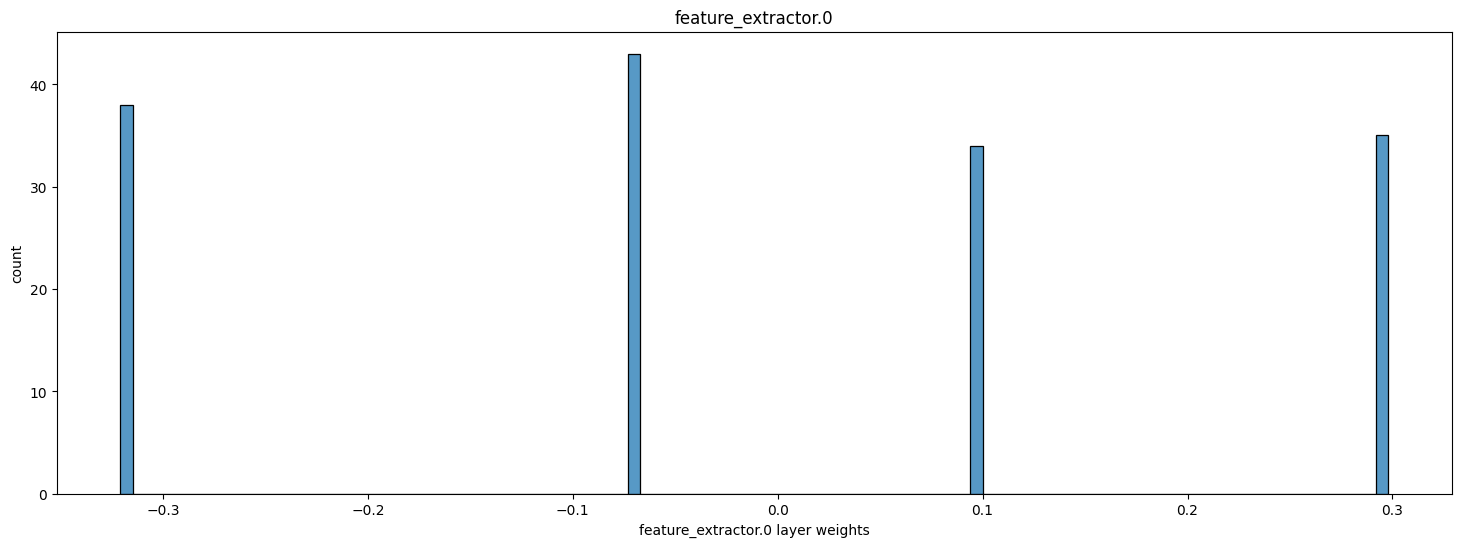

In [9]:
ws_controller.model_layers[0].plot_weight()

Setting scoring functions

In [10]:
before_loss = get_accuracy(model, dataset.test_dl, DEVICE)

lam_score1 = lambda _ : get_accuracy(model, dataset.test_dl, DEVICE)
lam_score2 = lambda layer : layer.compression_rate()
lam_score3 = lambda _ : (get_accuracy(model, dataset.test_dl, DEVICE) + get_accuracy(model, dataset.valid_dl, DEVICE)\
    + get_accuracy(model, dataset.train_dl, DEVICE)) / 3 

TEST - sharing whole network with pre score-functions

In [11]:
"""
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)

def pre_perf(layer):
    opt = lam_opt(model)
    lam_train(opt, 1)

ws_controller.get_layer_cluster_nums_perf(1, range(10,20), [lam_score1, lam_score2], pre_perf)
ws_controller.get_layer_cluster_nums_perf(1, range(10,100), [lam_score1, lam_score2])
"""

'\nlam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)\n\ndef pre_perf(layer):\n    opt = lam_opt(model)\n    lam_train(opt, 1)\n\nws_controller.get_layer_cluster_nums_perf(1, range(10,20), [lam_score1, lam_score2], pre_perf)\nws_controller.get_layer_cluster_nums_perf(1, range(10,100), [lam_score1, lam_score2])\n'

Getting optimal num of clusters for a given layer

In [12]:
data = {
    'num clusters': [],
    'accuracy': [],
    'layer': []
}

data_types = {
    'num clusters': 'int16',
    'accuracy': 'float32',
    'layer': 'uint8'
}

share_data = pd.DataFrame(data).astype(data_types)

for layer in [0, 4]:
    scores = ws_controller.get_layer_cluster_nums_perf(layer, range(2,3), [lam_score1])
    
    for item in scores:
        share_data = share_data.append({
            'num clusters': item[0],
            'accuracy loss': (before_loss - item[1][0]),
            'layer': layer,
        }, ignore_index=True).astype(data_types)

share_data.to_csv(SAVE_DATA, index=False)

Exception: Layer get_best_cluster_num error - Already altered weight cannot be precessed

Pot data

In [ ]:
plot_alncl(share_data)

After measurements the net is not changed

In [ ]:
ws_controller.print_layers_info()

In [ ]:
layer_ranges = [range(1, 10), range(1, 10), range(1, 10), range(1, 10), range(1, 10)]
lam_score1 = lambda _ : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller.get_optimized_layer_ranges(layer_ranges, lam_score1, 0.98, savefile='../results/lol.csv')